# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [1]:
# %matplotlib qt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format=' - %(levelname)s - %(message)s')

In [3]:
import poppy
import xupy as xp
from xupy import typing as xt
import astropy.units as u
from astropy import convolution as c
from astropy.io import fits
from astropy.table import QTable
from matplotlib import pyplot as plt
from opticalib import load_fits

Gpb = QTable.read("data/gaiaDR3passband.fits")
weights = Gpb.filled(0)

def rebinned(psf: fits.HDUList | xt.ArrayLike, rebin_factor: int) -> fits.HDUList:
    """
    Rebin PSF by a given factor, following Gaia's pixel scale (1:3 ratio).
    """
    if isinstance(psf, fits.HDUList):
        psf = psf[0].data
    px_ratio = (rebin_factor, 3*rebin_factor)
    return poppy.utils.rebin_array(psf, px_ratio)

 - INFO - Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
 - INFO - Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
 - INFO - NumExpr defaulting to 16 threads.
/home/pietrof/miniconda3/lib/python3.13/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')




[XuPy] Multiple GPUs detected:
       - gpu_id 0 : NVIDIA L40S | Memory = 45487.75 MB | Compute Capability = 8.9
       - gpu_id 1 : NVIDIA L40S | Memory = 45487.75 MB | Compute Capability = 8.9
       Using CuPy 13.4.1 for acceleration.


```py
poppy.conf.use_multiprocessing = False
poppy.conf.n_processes = 20
poppy.conf.double_precision = False

M1 = poppy.RectangleAperture(name="Primary Mirror", width=1.45*u.m, height=0.5*u.m)
M2 = poppy.RectangleAperture(name="Beam Collimator / Secondary Mirror",width=0.35*u.m, height=0.2*u.m)
telescope = poppy.OpticalSystem(name="Gaia", oversample=1, verbose=True)

telescope.add_pupil(M1)
telescope.add_detector(name="SkyPLANE", pixelscale=0.001*(u.arcsec/u.pixel), fov_arcsec=1*u.arcsec, oversample=10)

psf = telescope.calc_psf(progressbar=True, return_final=True, source={'wavelengths': Gpb['lambda'], 'weights': weights['G']})

## Got The PSF: Now on to the convolution

In [4]:
from simulator import BinarySystem, CCD

#### Creating the Binary star system

In [5]:
bs = BinarySystem(M1=5, M2=7, distance=200)

bs._band_flux()
bs.create_raw_binary_cube(collecting_area=1.45*0.5*u.m**2,t_integration=4.42*u.s, shape=(440,440))


#### Loading the PSF and creating the CCD

In [6]:
psf_file = "data/simulations/PSFs/gaia_psf_2.fits"
psf, psf_H = load_fits(psf_file, return_header=True)

for key in psf_H.keys():
    if key == 'HISTORY':
        print(f"{key}: {psf_H[key]}")
        break
    if 'WAVE' not in key and 'WGHT' not in key:
        print(f"{key}: {psf_H[key]}")

ccd = CCD(psf_file)

SIMPLE: True
BITPIX: -32
NAXIS: 2
NAXIS1: 10000
NAXIS2: 10000
EXTEND: True
PLANE1: Wavefront Intensity
DIFFLMT: 0.04303385928527069
OVERSAMP: 1
DET_SAMP: 1
PIXELSCL: 0.0001
FOV: 1.0
FFTTYPE: numpy.fft
NORMALIZ: first
HISTORY: Created wavefront: wavelength=320 nm, diam=1.534 m
 using array size (1024, 1024)
  Multiplied WF by phasor for Pupil plane: Primary Mirror
  Propagating wavefront to Detector plane: SkyPLANE (1000x1000 pixels, 0
.001 arcsec / pix).
    Propagating w/ MFT: 0.0001 arcsec / pix     fov=23.238 lam/D    npix
=10000
Calculation completed in 127.198 seconds


**First try at observation**

In [7]:
img = bs.map[0]
psf = ccd.psf.copy()

In [8]:
img_g = xp.asarray(img, dtype=xp.float)
psf_g = xp.asarray(psf, dtype=xp.float)

xdiff = psf_g.shape[1] - img_g.shape[1]
ydiff = psf_g.shape[0] - img_g.shape[0]
img_g = xp.pad(img_g, ((ydiff//2, ydiff//2), (xdiff//2, xdiff//2)), mode='constant')

In [9]:
c.convolve_fft(img_g, psf_g, normalize_kernel=True, boundary='wrap', nan_treatment='fill', fill_value=0.0)

AttributeError: module 'xupy' has no attribute 'ma'

### GPU FFT-Convolve

In [12]:
img1 = xp.fft.fftn(img_g)
psffft = xp.fft.fftn(xp.fft.ifftshift(psf_g))

fftmult = img1 * psffft
conv_img = xp.fft.ifftn(fftmult).real

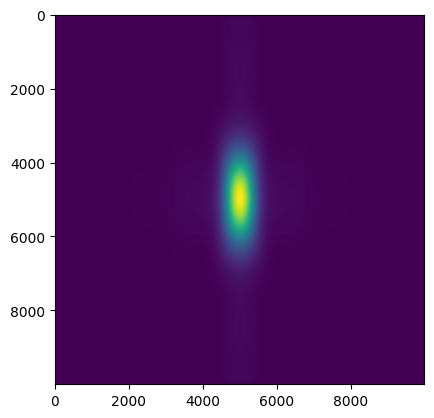

In [13]:
plt.imshow(conv_img.get())